<a href="https://colab.research.google.com/github/cjohnsoncruz/neural_network_correlation_shuffle/blob/main/pytorch_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based off of work done by Frost Et al in PlosBiology, 2021: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001235

## Goal:
Develop a set of neural networks that are able to evaluate the information content contained within the correlation structure of matrices containing neural time-series

In [18]:
### Import all the necessary libraries
#!pip install --upgrade numpy #need numppy 1.7 to use code
import scipy.io
import numpy as np
import matplotlib
import random 

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image
from torchvision.transforms import ToTensor


from google.colab import drive
drive.mount('/content/drive')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
print(np.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using cuda device
1.19.5


In [19]:
#CREATE A FUNCTION TAHT PERFORMS SHARC, compare to swap
def do_sharc_shuffle():
      #each raster is equivalent to a collection of blocks of activity. Each block of activity is defined by the time at which it begins, its duration, and the neuron which is active.  
  activity_blocks = list()
  block_info = {'begin':[], 'duration':[], 'ID':[]}
  pass

def do_swap_shuffle():
    pass

def create_empty_corr_matrix(raster):
        #INPUT: raster (neuron x frame input)
  og_corrs = np.corrcoef(raster)
  new_corrs = np.zeros(og_corrs.shape)
  return new_corrs
    #activity blocks must contain 1) a begin time 2) a duration and 3) neuron ID
    #each dict can contain all 3 
    #SHARC is an iterative method for generating surrogate datasets.
    
    #SHARC nonrandomly shuffles blocks of activity within a raster to generate a new (surrogate) raster in which the pairwise correlations between neurons match a target correlation matrix

In [20]:
# create class for framewise activity 
class raster_dataset(Dataset):
  """ neuron dataset"""
  def __init__(self, mat_filename, transform = None):
    mat = scipy.io.loadmat(mat_filename);
    self.spikes = torch.from_numpy(mat['spikes']) #convert numpy array of raster to tensor 
    self.transform = transform
    self.shape = self.spikes.shape
  def __len__(self):
    return self.spikes.shape[1]

  def __getitem__(self, index):
    sample = self.spikes[:,index]
    return sample 

  def get_slice(self, index):
    return self.spikes[:, index]

  def get_sub_slice(self, row_index, col_index):
    return self.spikes[row_index, col_index]

#create class to store information on feature vector
class feature_vec(Dataset):

  def __init__(self, labels):
    self.labels = torch.from_numpy(labels) #transform label vector into tensor

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, indx):
    return self.labels[indx]


def make_rand_labels(label_len):
  rand_vec = np.random.rand(1, label_len) >= 0.5
  return rand_vec.astype(int)

class label_raster_dataset(Dataset):
  """ combined label raster dataset""" 
  def __init__(self, raster, labels):
    self.raster = raster.spikes
    self.labels = labels.labels 
    self.num_neurons = self.raster.shape[0]
  
  def __len__(self):
    return self.labels.shape[0]

  def __getitem__(self, indx):
    raster = self.raster[:,indx]
    rep = raster.shape[0] #number of times to repeat the labels to match size of raster

    label = torch.from_numpy(np.tile(self.labels[0,indx], (rep,1)))
    return raster, label #outputs tuple of tensors



In [69]:
## NETWORK TRAINING AND PLOTTING RELATED FUNCTIONS
def single_epoch_train(x_train, y_train, model_train, predicted, losses, loss_function, optimizer, report_info):
    #report info is a dict explaining how to report stuff
    report_every = report_info['report freq'] #how many 
    s = report_info['s']

    optimizer.zero_grad() #zero gradient before calculating for each step
    output = model_train(x_train) 
    #calculate loss
    loss = loss_function(output, y_train.float())
    #accuracy
    predicted.append(output[0].item())
    #important backprop
    loss.backward()
    optimizer.step()
    losses.append(loss)
    #accur.append(acc)
    if s % report_every == 0:
      print('train ex' + str(s) + str(loss))
    return losses, predicted
    #print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))

def generate_train_index(full_len, train_len, train_type):
  if train_type == 'range':
      train_start = random.sample(list(np.arange(full_len-train_len-1)),1)
      print(type(train_start), train_start)

      train_range = list(np.arange(train_start[0],int(train_start[0]) + int(train_len))) #to get the range in the right dimensions for iteration
  elif train_type == 'rand':
      rand_nums = random.sample(list(np.arange(full_len)), train_len )    
      #rand_nums = np.random.randint(np.arange(full_len), (1,train_len), replace = True) #sample without replacement from range of ints
      #rand_nums = np.random.randint(0,full_len, (train_len,1)) #this is with replacement so I am a bit worried
      train_range = rand_nums
      #no, you want to pick N random nubmers from range -:full_len
  elif train_type == 'bool_range':
      bool_rand_length = np.random.randint(2, size=train_len).astype(bool) #2 exlucsive, so just 1 or 0
      train_range = np.arange(1,train_len+1)[bool_rand_length]
  return train_range

#temp placeholder function
def plot_performance(loss, predict):
  #set training range
  fig, ax = plt.subplots(2,1, figsize = (12,7))
  ax[0].plot(loss)
  ax[0].set_title('Model Training Loss')
  ax[1].plot(predict);
  ax[1].set_title('Output Layer Output ');

In [22]:
## NETWORK CLASS STORAGE

#build neural network
class myNet(nn.Module):
    def __init__(self, num_neurons): #input in the number of neurons you want to use 
        super(myNet, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(num_neurons, 1000) #num neurons IN, 1000 OUT
        self.fc2 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #REMOVING RELU because frost et al. just feed data directly from input to hidden layer
        #x = self.relu(x)#then apply relu
        x = self.fc2(x) #pass 2nd layer/output layer input (1000 ->1), 
        x = self.sigmoid(x) #then apply sigmoid for output
        return x


In [23]:
#test dropout 
m = nn.Dropout(p=0.2)
input = torch.randn(5, 5)
output = m(input)
output

tensor([[ 1.5882,  0.0000, -1.0676,  1.2393, -1.4661],
        [ 0.0988, -0.2681,  0.0000,  0.0000, -2.0770],
        [ 0.2670,  0.0000,  0.6036, -2.1668, -1.2254],
        [-0.3904, -0.8084,  1.1592,  0.8109,  0.5835],
        [ 0.7287,  0.2945, -0.0000, -0.3193,  0.6731]])

# IMPORT REAL DATA (spike raster and label vector)

In [24]:
filename = '/content/drive/MyDrive/' + 'Dx_7-1_RS1_VEH_Spikes_thresh.mat'
raster = raster_dataset(filename)
#import real (sample) label vector 
real_label_filename = '/content/drive/MyDrive/' + 'Dlx_C7-1_RS1_VEH_paddedLabels.mat'
label_mat = scipy.io.loadmat(real_label_filename);
label_mat


{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 15 11:42:01 2021',
 '__version__': '1.0',
 'pad_labels_7_1': array([[ 1,  1,  1, ..., 15, 15, 15]], dtype=uint8)}

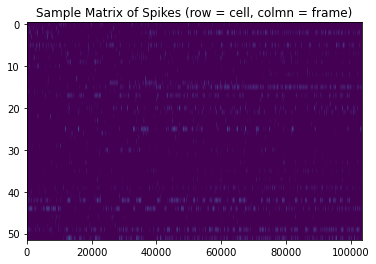

In [25]:

real_labels_array = label_mat['pad_labels_7_1']
real_labels_array
real_labels_object = feature_vec(real_labels_array)

plt.figure();#figsize = (4,4))
plt.imshow(raster.spikes, aspect = 'auto');
plt.title('Sample Matrix of Spikes (row = cell, colmn = frame)');

#make prediction and losses dict for later 
predictions_dict = dict()
losses_dict = dict()
report_info = dict()

### Create random surrogate dataset to test neural network on 

Now create a more structured dataset, where activity depends on the status of the boolean label. Can this network learn it?

In [75]:
def make_random_labels_raster(raster):
  rand_labels = make_rand_labels(len(raster))
  rand_labels = feature_vec(rand_labels)
  rand_dataset = label_raster_dataset(raster,rand_labels)
  #create NN network based on size of random raster (in turn based on real dataset)

  label_mask = rand_labels.labels[0]== 1
  label_mask = label_mask.numpy() #create numpy boolean mask for indexing

  d_raster_size = 50
  #create raster that is dependent on random labels
  dependent_raster = np.zeros((d_raster_size,len(label_mask)))
  dependent_raster[0:round(d_raster_size/2):3, label_mask] = 1
  dependent_raster[round(d_raster_size/2)+1::2, label_mask] = 1
  return rand_dataset, rand_labels, dependent_raster 

new raster shape is(50, 103362)


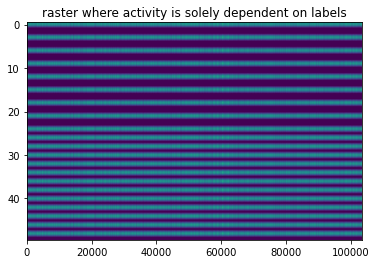

In [76]:
#create random dataset for testing function of NN
rand_dataset, rand_labels, dependent_raster = make_random_labels_raster(raster)
print('new raster shape is' + str(dependent_raster.shape))
plt.imshow(dependent_raster, aspect = 'auto');
plt.title('raster where activity is solely dependent on labels');

Optimizer is : SGD (
Parameter Group 0
    dampening: 0
    lr: 0.05
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss function is  BCELoss()
Device is cuda
model is myNet(
  (fc1): Linear(in_features=50, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
train ex3000tensor(0.0328, grad_fn=<BinaryCrossEntropyBackward0>)
train ex10200tensor(0.0138, grad_fn=<BinaryCrossEntropyBackward0>)
train ex14600tensor(0.0101, grad_fn=<BinaryCrossEntropyBackward0>)
train ex24800tensor(0.0047, grad_fn=<BinaryCrossEntropyBackward0>)


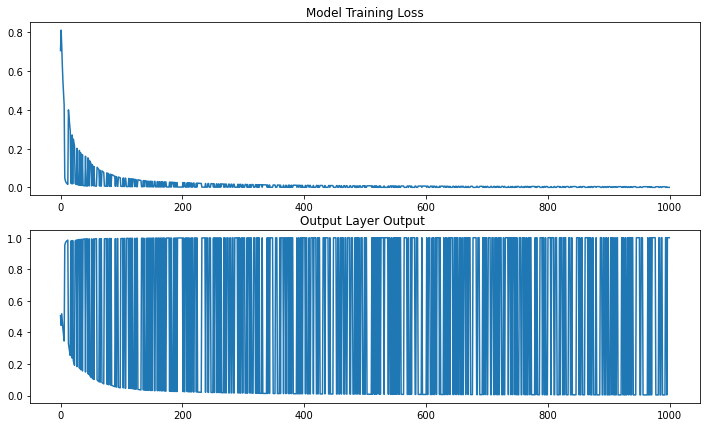

In [31]:
#create dependent_raster based model
depend_model = myNet(dependent_raster.shape[0]) 
predictions_dict['depend'] = []
losses_dict['depend'] = []
### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.SGD(depend_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', depend_model)

#TRAIN MODEL AND PLOT PERFORMANCE
depend_model.train()
num_train_examples = 1000

train_index = generate_train_index(round(raster.shape[1]/2),num_train_examples, 'rand')
report_info['report freq'] = int(round(num_train_examples/5)) #how many

for s in (train_index): 
  report_info['s'] = s
  x_train = torch.t(torch.from_numpy(dependent_raster[:,s]))  #transpose inputs to perform appropriate matrix multiplication for input layer
  y_train = rand_labels.labels[:,s]
  single_epoch_train(x_train, y_train, depend_model, predictions_dict['depend'], losses_dict['depend'], loss_function, optimizer, report_info)

plot_performance(losses_dict['depend'], predictions_dict['depend'])

As expected, a smaller neural network is able to learn the case where "neuron" activity is purely a function of the binary label vector.



Now, lets use **real** data to predict **real** class labels, using a sample dataset

In [32]:
#Note down what labels are equivalent to what behavior 
#""" Key for behavioral labels (for rule shifting):
#% buffer (before start of Anymaze; 30sec at end of baseline; 5sec at end of session) = 0
# baseline (start of Anymaze to 1st buffer) = 1
# start (pick up to start trial) = 2 (IA) or 9 (RS)
# pre-decision (start trial to start digging) = 3 (IA) or 10 (RS)
# digging (start digging to outcome) = 4 (IA) or 11 (RS)
# correct outcome (outcome to end trial) = 5 (IA) or 12 (RS)
# incorrect outcome (outcome to end trial) = 6 (IA) or 13 (RS)
# end (end trial to start ITI) = 7 (IA) or 14 (RS)
# ITI (start ITI to pick up) = 8 (IA) or 15 (RS) """

In [33]:
def make_oneHot_vector_singleBEI(label_vec, BEI, comparison):
  #INPUT must be numpy array

  if comparison == '=':
    feature_vec_bool = label_vec == BEI
  elif comparison == '>':
    feature_vec_bool = label_vec > BEI
  elif comparison == '<':
    feature_vec_bool = label_vec < BEI
  elif comparison == 'multi =': #check if eleemtn in list is = to any element of BEI list 
    print(BEI[0])
    feature_vec_bool = np.logical_or(label_vec == BEI[0], label_vec == BEI[1])
  #now prepare vec for output
  zero_vector = np.zeros((1, label_vec.shape[0]))
  zero_vector[0,feature_vec_bool] = 1
  return zero_vector



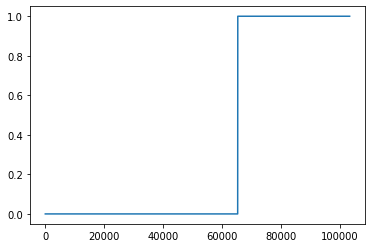

In [34]:
## Set up IS RS vector
zero_vector = make_oneHot_vector_singleBEI(real_labels_array[0], 8, '>')
labels_obj_isRS = feature_vec(zero_vector)
plt.plot(zero_vector[0,:]);


The input label vector is a categorical vector, where integers from 0-15 represent a behavioral state for the mouse during the task. This span actually represents two duplicate lists of behaviors: behaviors encoded by 1-8 are identical to the ones encoded by 9-15. Behaviors are categorized by whether they occur in the Rule 1 period, or Rule 2 period. Rule 1 behaviors are below 9, and Rule 2 behaviors are above 9.
For this first attempt at classification, I will one-hot encode whether a given frame is in the Rule 1 period (IA) or Rule 2 period (RS)

unique val and counts in train index are: [0. 1.]


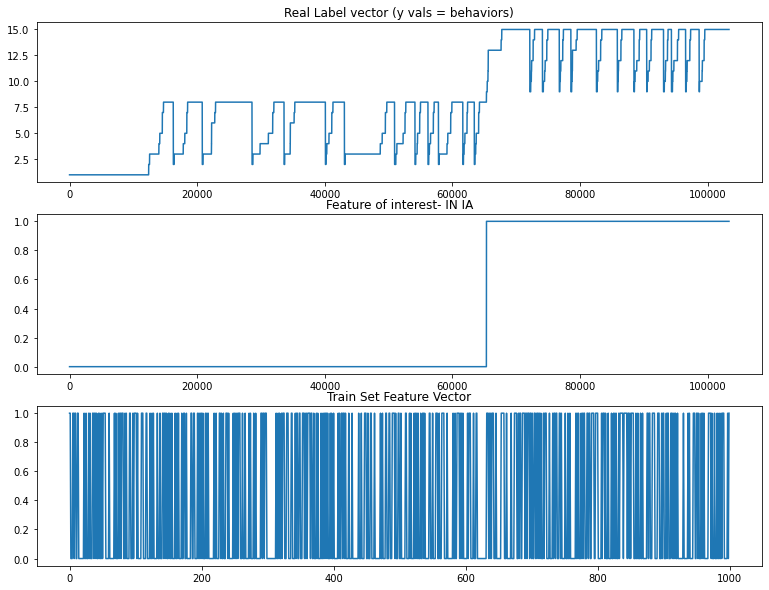

In [50]:
num_train_examples = 1000

train_index = generate_train_index(raster.shape[1],num_train_examples, 'rand')
print('unique val and counts in train index are:', np.unique(labels_obj_isRS.labels[0,train_index]))

fig, ax = plt.subplots(3,1, figsize = (13,10))
ax[0].plot(real_labels_array[0,:]);
ax[0].set_title('Real Label vector (y vals = behaviors)');

ax[1].plot(labels_obj_isRS.labels[0,:]);
ax[1].set_title('Feature of interest- IN IA');

ax[2].plot(labels_obj_isRS.labels[0,train_index]);
ax[2].set_title('Train Set Feature Vector');

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


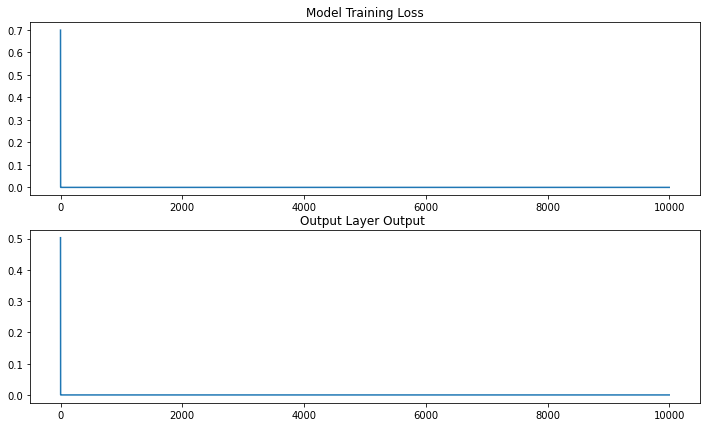

In [37]:
#decide if use GPU
use_GPU = True


#instantiate model and declare parameters
if use_GPU:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  isRS_model = myNet(raster.shape[0]).to(device) 
  print(f'Using {device} device')
else:
  isRS_model = myNet(raster.shape[0]) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.Adam(isRS_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', isRS_model)

#set up test train splits
predictions_dict['isRS'] = []
losses_dict['isRS']  = []

#TRAIN MODEL AND PLOT PERFORMANCE
isRS_model.train()
num_epochs= 10 #crashed after 52 minutes to reach epoch 450, so keep below 400
num_train_examples = 1000

for e in np.arange(num_epochs): 

  #generate a new training index each epoch 
  #set training range
  #seems like just randomly sampling overburdens in favor of dominant class, so you should cut it off 
  train_index = generate_train_index(round(raster.shape[1]/2),num_train_examples, 'rand')

  report_info['report freq'] = int(len(train_index)/5) #how many
  #if e+1 %25 == 0:
  print('Epoch: ', e+1 )

  for index, s in enumerate(train_index): 
    x_train = torch.t(raster.spikes[:,s])  #transpose inputs to perform appropriate matrix multiplication for input layer
    y_train = labels_obj_isRS.labels[:,s] #this is bool true false...
    if use_GPU:
      x_train, y_train = x_train.to(device), y_train.to(device)

    single_epoch_train(x_train, y_train, isRS_model, predictions_dict['isRS'], losses_dict['isRS'], loss_function, optimizer, report_info)

plot_performance(losses_dict['isRS'], predictions_dict['isRS'])

With 5000 training examples, a neural net architecture that was able to grasp the simple previous associations is unable to grasp the true information underlying what rule is present when, using single frames and SGD.

It's possible that information about status is on longer timescales than frames or 1/20th of seconds. Could try changing optimization function (to including momentum) or taking averages to slightly increase information available to network.

In [38]:
#try out dropout layers to mimic OG paper 
#try freezing first layer
#try adding momentum (e.g. ADAM optimizer )

Try a different feature vector to predict against. Next is a network trained on predicting the ITI period:


8
<class 'list'> [49190]
[49190, 49191, 49192, 49193, 49194, 49195, 49196, 49197, 49198, 49199, 49200, 49201, 49202, 49203, 49204, 49205, 49206, 49207, 49208, 49209, 49210, 49211, 49212, 49213, 49214, 49215, 49216, 49217, 49218, 49219, 49220, 49221, 49222, 49223, 49224, 49225, 49226, 49227, 49228, 49229, 49230, 49231, 49232, 49233, 49234, 49235, 49236, 49237, 49238, 49239, 49240, 49241, 49242, 49243, 49244, 49245, 49246, 49247, 49248, 49249, 49250, 49251, 49252, 49253, 49254, 49255, 49256, 49257, 49258, 49259, 49260, 49261, 49262, 49263, 49264, 49265, 49266, 49267, 49268, 49269, 49270, 49271, 49272, 49273, 49274, 49275, 49276, 49277, 49278, 49279, 49280, 49281, 49282, 49283, 49284, 49285, 49286, 49287, 49288, 49289, 49290, 49291, 49292, 49293, 49294, 49295, 49296, 49297, 49298, 49299, 49300, 49301, 49302, 49303, 49304, 49305, 49306, 49307, 49308, 49309, 49310, 49311, 49312, 49313, 49314, 49315, 49316, 49317, 49318, 49319, 49320, 49321, 49322, 49323, 49324, 49325, 49326, 49327, 49328, 4

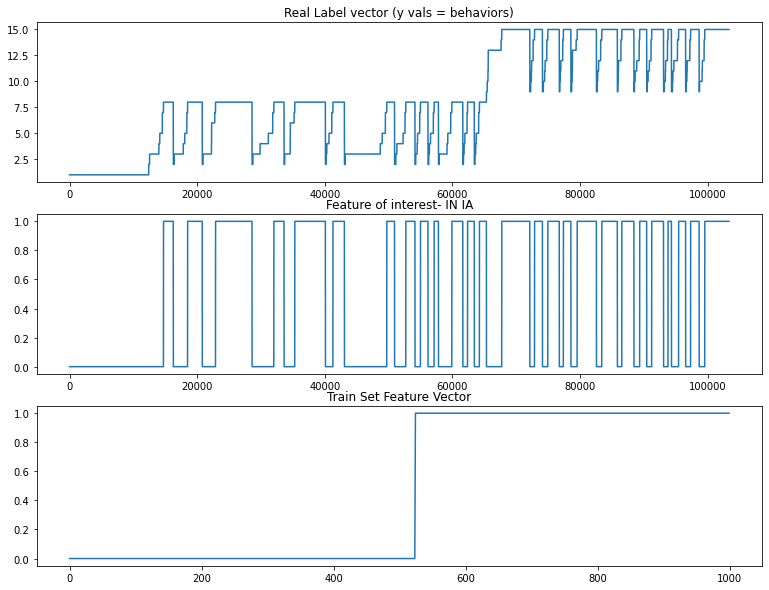

In [72]:
ITI_vec = make_oneHot_vector_singleBEI(real_labels_array[0], [8, 15], 'multi =')
labels_obj_ITI = feature_vec(ITI_vec)
num_train_examples = 1000

train_index = generate_train_index(raster.shape[1],num_train_examples, 'range')

fig, ax = plt.subplots(3,1, figsize = (13,10))
ax[0].plot(real_labels_array[0,:]);
ax[0].set_title('Real Label vector (y vals = behaviors)');

ax[1].plot(labels_obj_ITI.labels[0,:]);
ax[1].set_title('Feature of interest- IN IA');

ax[2].plot(labels_obj_ITI.labels[0,train_index]);
ax[2].set_title('Train Set Feature Vector');
print(train_index)
print(labels_obj_ITI.labels[0,train_index[2]])

Optimizer is : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
loss function is  BCELoss()
Device is cuda
model is myNet(
  (fc1): Linear(in_features=52, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


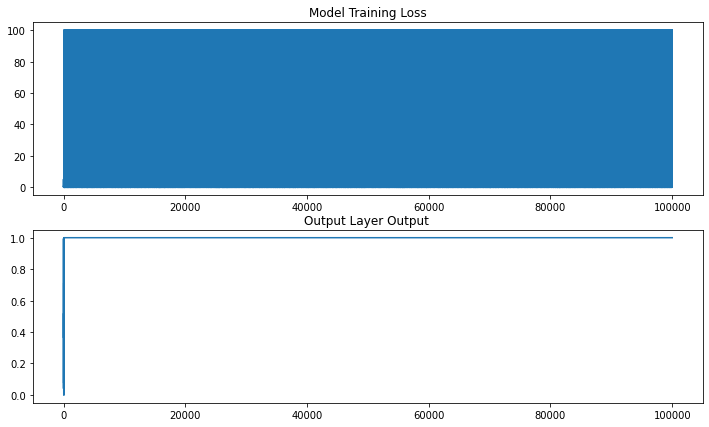

In [74]:
#decide if use GPU
use_GPU = False

#set up test train splits
predictions_dict['isITI'] = []
losses_dict['isITI']  = []

#instantiate model and declare parameters
if use_GPU:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  isITI_model = myNet(raster.shape[0]).to(device) 
  print(f'Using {device} device')
else:
  isITI_model = myNet(raster.shape[0]) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.Adam(isITI_model.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', isITI_model)

#TRAIN MODEL AND PLOT PERFORMANCE
isITI_model.train()
num_epochs= 10 #crashed after 52 minutes to reach epoch 450, so keep below 400
num_train_examples = 10000

for e in np.arange(num_epochs): 

  #generate a new training index each epoch 
  #set training range
  #seems like just randomly sampling overburdens in favor of dominant class, so you should cut it off 
  train_index = generate_train_index(raster.shape[1],num_train_examples, 'rand')

  report_info['report freq'] = int(len(train_index)/5) #how many
  #if e+1 %25 == 0:
  print('Epoch: ', e+1 )

  for index, s in enumerate(train_index): 
    x_train = torch.t(raster.spikes[:,s])  #transpose inputs to perform appropriate matrix multiplication for input layer
    y_train = labels_obj_ITI.labels[:,s] #this is bool true false...
    if use_GPU:
      x_train, y_train = x_train.to(device), y_train.to(device)

    single_epoch_train(x_train, y_train, isITI_model, predictions_dict['isITI'], losses_dict['isITI'], loss_function, optimizer, report_info)

plot_performance(losses_dict['isITI'], predictions_dict['isITI'])

It is possible lack of dropout is hindering training. I thus now construct a Network with dropout 

## DROPOUT TEST


In [81]:

#build neural network
class myNet_dropout(nn.Module):
    def __init__(self, num_neurons, dropout_proportion): #input in the number of neurons you want to use 
        super(myNet_dropout, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(num_neurons, 1000) #num neurons IN, 1000 OUT
        self.fc_linear = nn.Linear(1000,1000) #layer for passing the dropout through 
        self.fc2 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_proportion)
        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #REMOVING RELU because frost et al. just feed data directly from input to hidden layer
        #x = self.relu(x)#then apply relu
        x = self.fc_linear(x)
        x = self.dropout(x)
        x = self.fc2(x) #pass 2nd layer/output layer input (1000 ->1), 
        x = self.sigmoid(x) #then apply sigmoid for output
        return x

In [82]:
# test with dropout
#decide if use GPU
use_GPU = False

#set up test train splits
predictions_dict['isITI'] = []
losses_dict['isITI']  = []

#instantiate model and declare parameters
if use_GPU:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  isITI_model_dropout = myNet(raster.shape[0]).to(device) 
  print(f'Using {device} device')
else:
  isITI_model_dropout = myNet_dropout(raster.shape[0], 0.3) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.Adam(isITI_model_dropout.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', isITI_model_dropout)

Optimizer is : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
loss function is  BCELoss()
Device is cuda
model is myNet_dropout(
  (fc1): Linear(in_features=52, out_features=1000, bias=True)
  (fc_linear): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)


This neural network does not reduce its loss either. It is possible a neural network that is this shallow is unable to learn the output. I will construct a doubly thick neural network to predict this.

## DEEP NN TEST 

In [43]:

#build neural network that has an extra hidden layer, see what you get
class double_thick_Net(nn.Module):
    def __init__(self, num_neurons): #input in the number of neurons you want to use 
        super(double_thick_Net, self).__init__()

        #self.encoder = nn.Sequential(nn.Linear(num_neurons,1000),nn.ReLU(),nn.Linear(1000,1),)
        self.fc1 = nn.Linear(num_neurons, 1000) #num neurons IN, 1000 OUT
        self.fc2 = nn.Linear(1000,1000) #ADDED: second hidden layer for non linearity 
        self.fc3 = nn.Linear(1000, 1) #1000 neurons in, 1 OUT
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        #create output layer

    def forward(self, x):
        #need to transpose X, as linear layers require (, Xin) shaped tensors
        x = self.fc1(x.float()) #pass 1st layer input (numNeurons ->1000),
        #REMOVING RELU because frost et al. just feed data directly from input to hidden layer
        #x = self.relu(x)#then apply relu
        
        x = self.fc2(x) #pass 2nd layer/output layer input (1000 ->1), 
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x) #then apply sigmoid for output
        return x


Optimizer is : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.05
    weight_decay: 0
)
loss function is  BCELoss()
Device is cuda
model is double_thick_Net(
  (fc1): Linear(in_features=52, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


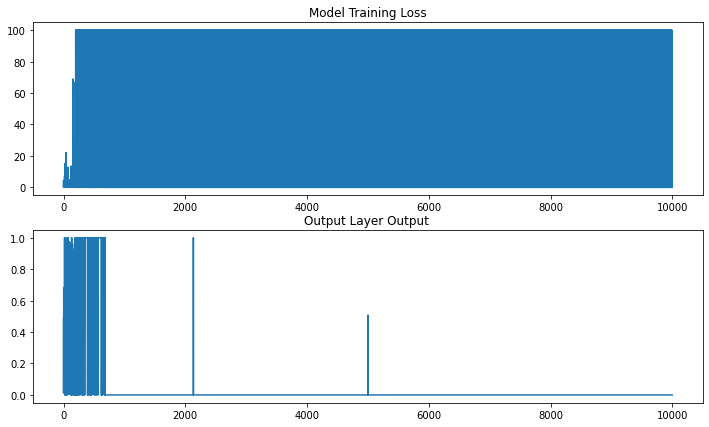

In [45]:
#decide if use GPU
use_GPU = False

#split name
condition_name = 'isITI_doubleNet'
#set up test train splits
predictions_dict[condition_name] = []
losses_dict[condition_name]  = []

#instantiate model and declare parameters
if use_GPU:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  isITI_model_double = double_thick_Net(raster.shape[0]).to(device) 
  print(f'Using {device} device')
else:
  isITI_model_double= double_thick_Net(raster.shape[0]) 

### Define your loss function (training criterion)
### Choose your optimizer
learning_rate = 0.05 #0.05 is learning rate from frost et al
optimizer = torch.optim.Adam(isITI_model_double.parameters(),lr=learning_rate)
loss_function = nn.BCELoss()

# gather all variables 
print("Optimizer is :", optimizer)
print("loss function is ", loss_function)
print("Device is", device)
print('model is', isITI_model_double)

#TRAIN MODEL AND PLOT PERFORMANCE
isITI_model_double.train()
num_epochs= 10 #crashed after 52 minutes to reach epoch 450, so keep below 400
num_train_examples = 500

for e in np.arange(num_epochs): 

  #generate a new training index each epoch 
  #set training range
  #seems like just randomly sampling overburdens in favor of dominant class, so you should cut it off 
  train_index = generate_train_index(round(raster.shape[1]/2),num_train_examples, 'rand')

  report_info['report freq'] = int(len(train_index)/5) #how many
  #if e+1 %25 == 0:
  print('Epoch: ', e+1 )

  for index, s in enumerate(train_index): 
    x_train = torch.t(raster.spikes[:,s])  #transpose inputs to perform appropriate matrix multiplication for input layer
    y_train = labels_obj_ITI.labels[:,s] #this is bool true false...
    if use_GPU:
      x_train, y_train = x_train.to(device), y_train.to(device)

    single_epoch_train(x_train, y_train, isITI_model_double, predictions_dict['isITI'], losses_dict['isITI'], loss_function, optimizer, report_info)

plot_performance(losses_dict['isITI'], predictions_dict['isITI'])